## init

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression as SklearnLinearRegression

import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
# украшаем графики
plt.rcParams["figure.figsize"] = (17,8)
plt.style.use('ggplot')

## data

In [18]:
X, y = make_regression(n_samples=100, n_features=2, n_informative=2)

In [19]:
X[:5]

array([[ 0.81210244,  1.34570186],
       [-0.21594788, -0.2250352 ],
       [ 0.47795566,  0.8963987 ],
       [-1.16793717, -1.39053198],
       [-0.18892968, -0.29445037]])

In [20]:
y[:5]

array([ 104.19929841,  -17.62301195,   69.25335902, -108.48391828,
        -22.82743741])

## baseline

In [23]:
slr = SklearnLinearRegression(fit_intercept=True)
slr = slr.fit(X, y)

y_pred = slr.predict(X)

mean_squared_error(y, y_pred)

2.2501320549104414e-28

In [26]:
baseline_coefs = [slr.intercept_] + list(slr.coef_)

baseline_coefs

[-8.881784197001252e-16, 2.4738988659156895, 75.93824605373288]

## LinearRegression

Итак, у нас n фичей и m объектов (векторов $ x^{(i)} $ длины n) - матрица X. Есть вектор y длины m с целевой - по одному значению на объект $ x^{(i)} $. Функция для приближения - линейная:    
$$ \hat{y} = h_\theta(x) :=\sum\limits_{j=0}^n \theta_j x_j $$  

($ \hat{y} $ - предсказанное значение; $ h_\theta(x) $ - обозначение для нашей итоговой функции)

Наша задача - найти оптимальные коэффициенты (вектор $ \theta $), которые минимизируют квадратичную функцию потерь (на данном датасете X):  
$$ L(\theta, X) = \frac{1}{2}\sum\limits_{i=1}^m (h_\theta(x)^{(i)} - y^{(i)})^2 $$  

> здесь мы берем $ \frac{1}{2} $ вместо $ \frac{1}{m} $ (что дало бы нам среднюю квадратичную ошибку) для более удобного дифференцирования. Какой бы множитель мы не добавили, минимум от этого не сместится.  

Частная производная по j-той координате вектора $ \theta $ на нескольких объектах (батче длины m) будет такой:  
$$ \frac {\partial }{\partial \theta_j} (\frac{1}{2}\sum\limits_{i=1}^m (h_\theta(x)^{(i)} - y^{(i)})^2) = \sum\limits_{i=1}^m x_j^{(i)}(h_\theta(x)^{(i)} - y^{(i)}) $$  

In [6]:
class LinearRegression():
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept # если True - добавляем фиктивный признак, у всех объектов равный 1
        
    def one_object_predict(self, x: np.array, theta: np.array) -> float:
        # предсказание для одного объекта
        if self.fit_intercept and (len(x) < len(theta)):
            x = np.insert(x, 0, 1) # добавляем фиктивный признак
        return np.sum(x * theta)
    
    def one_object_gradient(self, x: np.array, theta: np.array, y: float) -> np.array:
        # считаем градиент на одном объекте (там же сумма, можно для батча просуммировать)
        if self.fit_intercept and (len(x) < len(theta)):
            x = np.insert(x, 0, 1) # добавляем фиктивный признак
        predict = self.one_object_predict(x, theta) # float
        diff = (predict - y) # float
        return x * diff # array (new theta)
    
    def batch_gradient(self, X: np.array, theta: np.array, y: np.array) -> np.array:
        # считаем градиент на батче
        # X - уже матрица, а не вектор; y - вектор, а не скаляр
        if self.fit_intercept and (len(X[0]) < len(theta)):
            X = np.insert(X, 0, 1, axis=1) # добавляем фиктивный признак
        gradient = np.zeros_like(theta)
        for x_i, y_i in zip(X, y):
            gradient = gradient + self.one_object_gradient(x_i, theta, y_i)
        return gradient
    
    def batch_predict(self, X: np.array, theta: np.array) -> np.array:
        # предсказание для батча
        # X - уже матрица, а не вектор; на выходе - вектор, а не скаляр
        if self.fit_intercept and (len(X[0]) < len(theta)):
            X = np.insert(X, 0, 1, axis=1) # добавляем фиктивный признак
        y_pred = []
        for x_i in X:
            y_pred.append(self.one_object_predict(x_i, theta))
        return np.array(y_pred)
    
    def initial_theta(self, X: np.array, y: np.array) -> np.array:
        # какой-то набор кэфов, с которого начнем спуск.
        if self.fit_intercept:
            X = np.insert(X, 0, 1, axis=1) # добавляем фиктивный признак
        return np.ones_like(X[0]) # просто единички
    
    def one_object_loss(self, x: np.array, theta: np.array, y: float) -> float:
        # значение функции потерь для одного объекта
        if self.fit_intercept and (len(x) < len(theta)):
            x = np.insert(x, 0, 1) # добавляем фиктивный признак
        predict = self.one_object_predict(x, theta)
        return 0.5 * (predict - y)**2
    
    def batch_loss(self, X: np.array, theta: np.array, y: np.array) -> float:
        # значение функции потерь на батче
        if self.fit_intercept and (len(X[0]) < len(theta)):
            X = np.insert(X, 0, 1, axis=1) # добавляем фиктивный признак
        loss = 0
        for x_i, y_i in zip(X, y):
            loss = loss + self.one_object_loss(x_i, theta, y_i)
        return loss

Собственно к линейной регрессии относится только это:  
* $ h_\theta $, функция-гипотеза, как строится предсказание;  
* _L_, функция потерь;  
* способ расчета градиента функции потерь.

А дальше - градиентный спуск.

In [7]:
lr = LinearRegression()

lr.one_object_predict(
    np.array([1,2]),
    np.array([1, 1, 1])
)

4

In [8]:
lr.one_object_gradient(
    np.array([1,2]),
    np.array([1, 1, 1]),
    4
)

array([0, 0, 0])

## SGD

Добавляем случайности: не на всем считаем градиент на каждом шагу, а по одной записи. И сразу добавим минибатч: не по одной записи, а по небольшому кусочку. Если размер батча поставить в 1 - будет чистый SGD. А если в кол-во записей - будет просто GD, без S.

In [28]:
class SGD():
    def __init__(
        self, 
        learning_rate=0.1, 
        mini_batch_size=16, 
        max_epoch_count=100, 
        round_ndigits=10, 
        random_seed=0
    ):
        self.learning_rate = learning_rate
        self.mini_batch_size = mini_batch_size
        self.max_epoch_count = max_epoch_count
        self.round_ndigits = round_ndigits
        self.random_seed = random_seed
    
    
    def batch_generator(self, X: np.array, y: np.array):
        assert len(X) == len(y)
        
        np.random.seed(seed=self.random_seed) # инициализируем генератор (псевдо)случайных чисел
        
        indices = np.arange(len(X)) 
        self.epoch_count = 0
        while self.epoch_count < self.max_epoch_count:
            np.random.shuffle(indices) # shuffle data before each epoch
            batch = []
            for i in indices:
                batch.append(i)
                if len(batch) == self.mini_batch_size:
                    yield X[batch], y[batch]
                    batch=[]
            self.epoch_count += 1
            
            
    def check_converge(self, gradient: np.array) -> bool:
        # проверяем, не достаточно ли мы близки к нулю (с точностью до self.round_ndigits знака)
        return np.all(np.abs(gradient.round(self.round_ndigits)) == 0)
    
    
    def get_step(self, gradient: np.array) -> np.array:
        # вектор смещения, который прибавляем к текущей точке
        # пока всё просто, но потом именно здесь будут усложнения
        return -1 * self.learning_rate * gradient
    
    
    def fit(self, model, X: np.array, y: np.array) -> np.array:
        np.random.seed(seed=self.random_seed) # инициализируем генератор (псевдо)случайных чисел
        
        loss_history = []
        
        theta = model.initial_theta(X, y)
        for x_i, y_i in self.batch_generator(X, y):
            
            loss_history.append(model.batch_loss(X, theta, y))
            
            gradient = model.batch_gradient(x_i, theta, y_i)
            if self.check_converge(gradient):
                print('exit because converge')
                break
            theta = theta + self.get_step(gradient)
        
        # plot loss
        ax = plt.axes()
        ax.plot(loss_history)
        plt.show();
            
        return theta

In [29]:
sgd = SGD(mini_batch_size=2, max_epoch_count=3)

for x_i, y_i in sgd.batch_generator(
    pd.DataFrame({1:[1,2,3], 2:[1,2,3], 3:[1,2,3]}).values, 
    np.array([1,2,3])
):
    print(pd.concat([pd.DataFrame(x_i), pd.Series(y_i).to_frame()], axis=1))

   0  1  2  0
0  3  3  3  3
1  2  2  2  2
   0  1  2  0
0  1  1  1  1
1  3  3  3  3
   0  1  2  0
0  1  1  1  1
1  2  2  2  2


In [30]:
sgd.check_converge(np.array([0.00000001, -0.0000000002]))

False

exit because converge


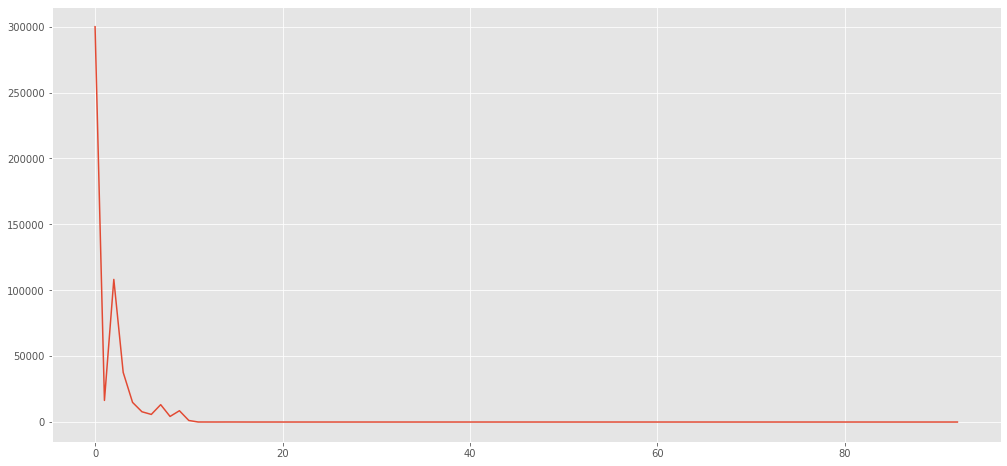

5.846663330803156e-24

In [31]:
lr = LinearRegression()
sgd = SGD(learning_rate=0.5, round_ndigits=10, max_epoch_count=200, mini_batch_size=8, random_seed=0)

coefs = sgd.fit(lr, X, y)

y_pred = lr.batch_predict(X, coefs)

mean_squared_error(y, y_pred)

In [32]:
coefs

array([1.90728243e-12, 2.47389887e+00, 7.59382461e+01])

## Adam

Добавим пару моментов (в прямом смысле: момент 1 и момент 2)

In [43]:
class ADAM(SGD):
    def __init__(
        self, 
        learning_rate=0.1, 
        mini_batch_size=16, 
        max_epoch_count=100, 
        round_ndigits=10, 
        random_seed=0,
        b_1 = 0.9,
        b_2 = 0.999,
        e=10**(-8)
    ):
        self.learning_rate = learning_rate
        self.mini_batch_size = mini_batch_size
        self.max_epoch_count = max_epoch_count
        self.round_ndigits = round_ndigits
        self.random_seed = random_seed
        self.b_1 = b_1
        self.b_2 = b_2
        self.e = e
    
            
    def get_step(
        self, gradient: np.array, moment_1: np.array, moment_2: np.array, steps_counter: int
    ) -> np.array:
        # вектор смещения, который прибавляем к текущей точке
        m_1 = self.b_1 * moment_1 + (1 - self.b_1) * gradient
        m_1_corr = m_1 / (1 - self.b_1**steps_counter)
        
        m_2 = self.b_2 * moment_2 + (1 - self.b_2) * gradient * gradient
        m_2_corr = m_2 / (1 - self.b_2**steps_counter)
        
        step = -1 * self.learning_rate * m_1_corr / (np.sqrt(m_2_corr) + self.e)
        
        return step, m_1, m_2
    
    
    def fit(self, model, X: np.array, y: np.array) -> np.array:
        np.random.seed(seed=self.random_seed) # инициализируем генератор (псевдо)случайных чисел
        
        loss_history = []
        
        theta = model.initial_theta(X, y)
        
        steps_counter = 0
        moment_1 = np.zeros_like(theta)
        moment_2 = np.zeros_like(theta)
        
        for x_i, y_i in self.batch_generator(X, y):
            loss_history.append(model.batch_loss(X, theta, y))
            
            gradient = model.batch_gradient(x_i, theta, y_i)
            steps_counter += 1
            if self.check_converge(gradient):
                print(f'exit because converge on step {steps_counter}')
                break
            step, moment_1, moment_2 = self.get_step(gradient, moment_1, moment_2, steps_counter)
            theta = theta + step
            
        
        # plot loss
        ax = plt.axes()
        ax.plot(loss_history)
        plt.show();
            
        return theta

exit because converge on step 1057


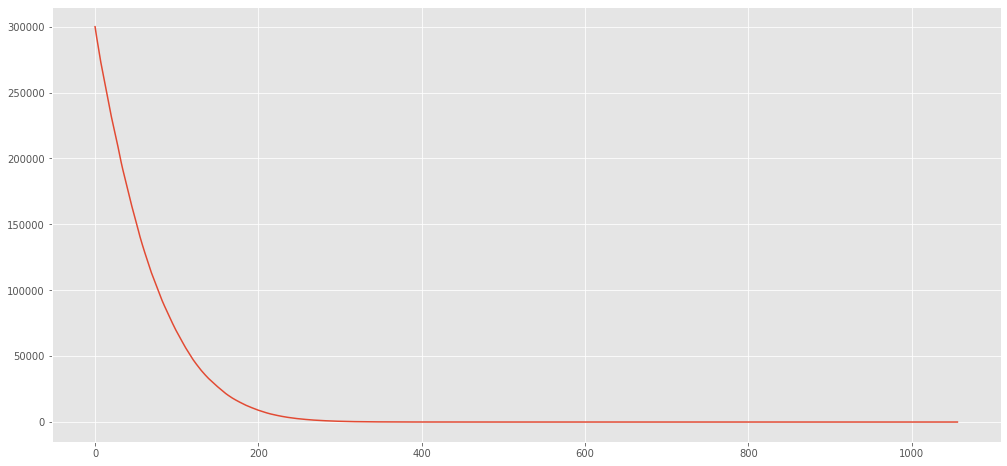

4.83630084137239e-22

In [53]:
lr = LinearRegression()
sgd = ADAM(learning_rate=0.5, round_ndigits=10, max_epoch_count=200, mini_batch_size=8, random_seed=0)

coefs = sgd.fit(lr, X, y)

y_pred = lr.batch_predict(X, coefs)

mean_squared_error(y, y_pred)

In [54]:
coefs

array([6.59015539e-12, 2.47389887e+00, 7.59382461e+01])

Кривая потерь убывает стабильнее )